/tmp/ipython-input-3946218575.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start="2020-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 330ms/step - loss: 2.5970 - val_loss: 0.0096
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 372ms/step - loss: 0.0137 - val_loss: 0.0396
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 269ms/step - loss: 0.0085 - val_loss: 0.0352
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 269ms/step - loss: 0.0073 - val_loss: 0.0221
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - loss: 0.0056 - val_loss: 0.0144
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 270ms/step - loss: 0.0040 - val_loss: 0.0101
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 302ms/step - loss: 0.0038 - val_loss: 0.0063
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 264ms/step - loss: 0.0035 - val_loss: 0.0021
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 363ms/step - loss: 0.0036 - val_loss: 0.0020
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 268ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 

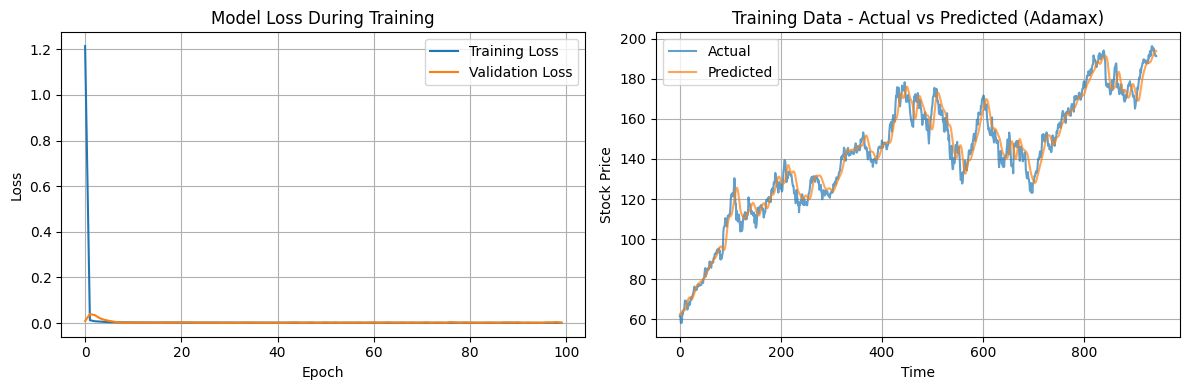

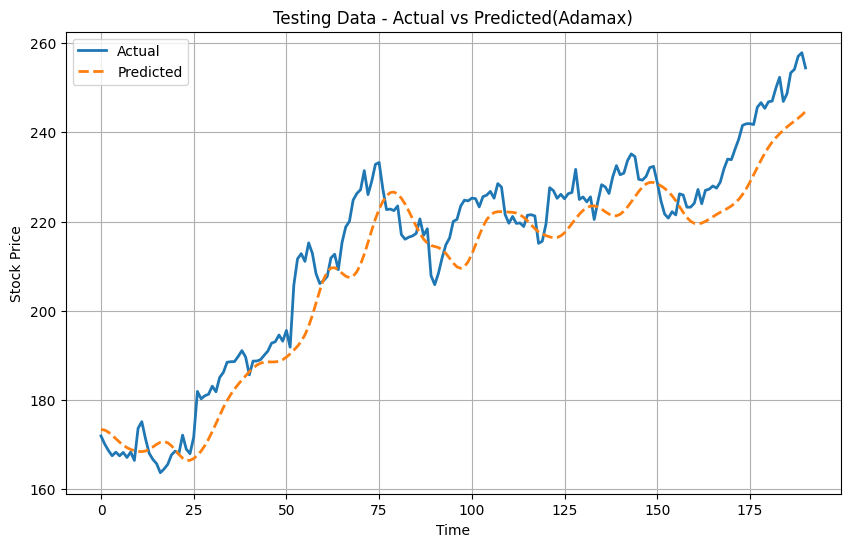

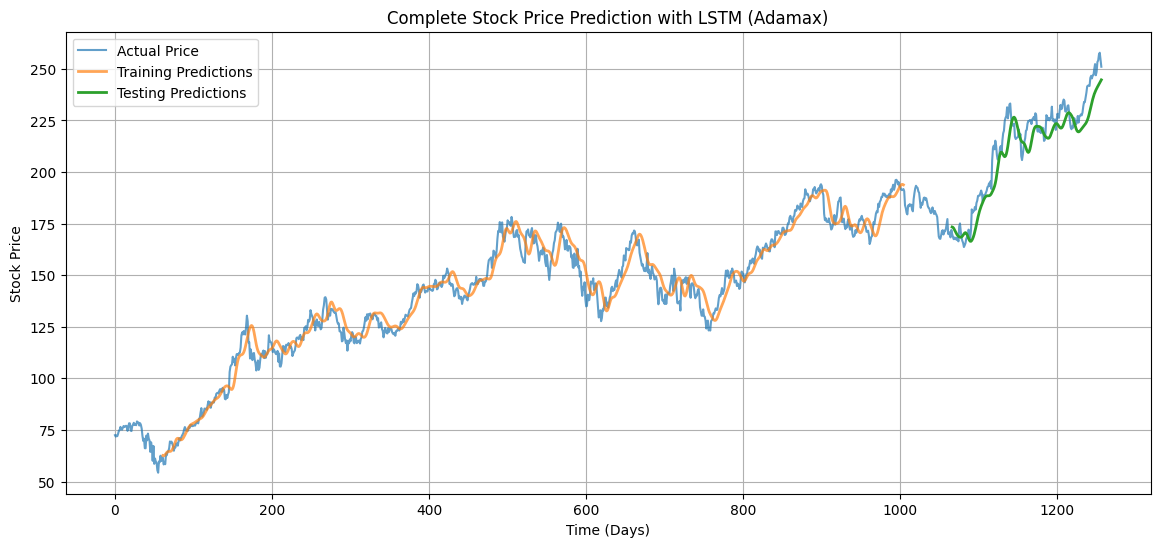

In [ ]:
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adamax

# Download historical stock data (e.g., Japanese stock)
data = yf.download("AAPL", start="2020-01-01", end="2024-12-31")
data = data[["Close"]]  # Use only closing price

# Normalize data
scaler = MinMaxScaler()
data["Close"] = scaler.fit_transform(np.array(data["Close"]).reshape(-1, 1))

# Split data into training and testing sets
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]

# Create dataset with lookback period
def create_dataset(dataset, look_back=60):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset['Close'][i:(i + look_back)].values  # Access 'Close' column
        X.append(a)
        Y.append(dataset['Close'].iloc[i + look_back])
    return np.array(X), np.array(Y)

look_back = 60
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create LSTM model
model = Sequential()

# First LSTM layer with return sequences for stacking
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # Dropout for regularization

# Second LSTM layer
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))

# Third LSTM layer
model.add(LSTM(units=100))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(1))

# Compile model with Adamax optimizer
model.compile(
    loss='mean_squared_error',
    optimizer=Adamax(learning_rate=0.01)  # Using Adamax optimizer
)


# Train model
history = model.fit(
    X_train,
    Y_train,
    epochs=100,
    batch_size=64,
    verbose=1,
    validation_data=(X_test, Y_test)  # Added validation for better monitoring
)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
Y_train_original = scaler.inverse_transform(Y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
Y_test_original = scaler.inverse_transform(Y_test.reshape(-1, 1))

# Evaluate the model - Basic metrics
train_rmse = math.sqrt(mean_squared_error(Y_train_original, train_predict))
test_rmse = math.sqrt(mean_squared_error(Y_test_original, test_predict))
print(f'Train RMSE: {train_rmse:.3f}')
print(f'Test RMSE: {test_rmse:.3f}')

train_mae = mean_absolute_error(Y_train_original, train_predict)
test_mae = mean_absolute_error(Y_test_original, test_predict)
print(f'Train MAE: {train_mae:.3f}')
print(f'Test MAE: {test_mae:.3f}')

# ========== CALCULATE SUCCESS RATES ==========
print("\n" + "="*60)
print("SUCCESS RATE CALCULATIONS")
print("="*60)

# 1. Direction Accuracy (Up/Down Prediction)
def calculate_direction_accuracy(actual, predicted):
    """
    Calculate accuracy of predicting price direction (up/down)
    """
    # Calculate actual direction (1 for up, 0 for down, -1 for no change)
    actual_direction = np.sign(np.diff(actual.flatten()))
    predicted_direction = np.sign(np.diff(predicted.flatten()))

    # Align arrays (remove first element since we're comparing directions)
    min_len = min(len(actual_direction), len(predicted_direction))
    actual_direction = actual_direction[:min_len]
    predicted_direction = predicted_direction[:min_len]

    # Calculate accuracy for non-zero directions
    non_zero_mask = (actual_direction != 0) & (predicted_direction != 0)
    if np.sum(non_zero_mask) > 0:
        accuracy = np.mean(actual_direction[non_zero_mask] == predicted_direction[non_zero_mask])
    else:
        accuracy = 0

    return accuracy * 100

# 2. Percentage Error Accuracy (Within X% of actual price)
def calculate_percentage_error_accuracy(actual, predicted, threshold_percent=5):
    """
    Calculate percentage of predictions within threshold_percent of actual price
    """
    percentage_errors = np.abs((actual - predicted) / actual) * 100
    within_threshold = percentage_errors <= threshold_percent
    accuracy = np.mean(within_threshold) * 100
    return accuracy, percentage_errors.mean()

# 3. Trend Following Accuracy (Multiple consecutive correct predictions)
def calculate_trend_following_accuracy(actual, predicted, window=3):
    """
    Calculate accuracy of following trends (multiple consecutive predictions)
    """
    actual_direction = np.sign(np.diff(actual.flatten()))
    predicted_direction = np.sign(np.diff(predicted.flatten()))

    min_len = min(len(actual_direction), len(predicted_direction))
    actual_direction = actual_direction[:min_len]
    predicted_direction = predicted_direction[:min_len]

    correct = (actual_direction == predicted_direction)

    # Calculate rolling accuracy for trend following
    trend_accuracy = []
    for i in range(len(correct) - window + 1):
        if np.sum(correct[i:i+window]) == window:  # All predictions in window are correct
            trend_accuracy.append(1)
        else:
            trend_accuracy.append(0)

    return np.mean(trend_accuracy) * 100 if trend_accuracy else 0

# Calculate success rates for training data
train_direction_acc = calculate_direction_accuracy(Y_train_original, train_predict)
train_percent_acc, train_mean_percent_error = calculate_percentage_error_accuracy(Y_train_original, train_predict, threshold_percent=5)
train_trend_acc = calculate_trend_following_accuracy(Y_train_original, train_predict, window=3)

# Calculate success rates for testing data
test_direction_acc = calculate_direction_accuracy(Y_test_original, test_predict)
test_percent_acc, test_mean_percent_error = calculate_percentage_error_accuracy(Y_test_original, test_predict, threshold_percent=5)
test_trend_acc = calculate_trend_following_accuracy(Y_test_original, test_predict, window=3)

# Print success rate results
print(f"\nTRAINING DATA SUCCESS RATES:")
print(f"1. Direction Prediction Accuracy: {train_direction_acc:.2f}%")
print(f"2. Predictions within 5% of actual price: {train_percent_acc:.2f}%")
print(f"   (Mean Percentage Error: {train_mean_percent_error:.2f}%)")
print(f"3. 3-Day Trend Following Accuracy: {train_trend_acc:.2f}%")

print(f"\nTESTING DATA SUCCESS RATES:")
print(f"1. Direction Prediction Accuracy: {test_direction_acc:.2f}%")
print(f"2. Predictions within 5% of actual price: {test_percent_acc:.2f}%")
print(f"   (Mean Percentage Error: {test_mean_percent_error:.2f}%)")
print(f"3. 3-Day Trend Following Accuracy: {test_trend_acc:.2f}%")

# Calculate overall success score (weighted average)
def calculate_overall_success_score(direction_acc, percent_acc, trend_acc):
    """Calculate weighted overall success score"""
    weights = [0.4, 0.4, 0.2]  # Weights for direction, percentage, and trend accuracy
    return direction_acc * weights[0] + percent_acc * weights[1] + trend_acc * weights[2]

train_overall_score = calculate_overall_success_score(train_direction_acc, train_percent_acc, train_trend_acc)
test_overall_score = calculate_overall_success_score(test_direction_acc, test_percent_acc, test_trend_acc)

print(f"\nOVERALL SUCCESS SCORES (Weighted Average):")
print(f"Training Data Overall Score: {train_overall_score:.2f}%")
print(f"Testing Data Overall Score: {test_overall_score:.2f}%")
print("="*60)

# 4. Trading Simulation Success (If we traded based on predictions)
def simulate_trading(actual, predicted, initial_balance=10000):
    """
    Simulate simple trading based on predictions
    """
    balance = initial_balance
    position = 0  # 0 = no position, 1 = long position
    trades = []

    for i in range(1, len(actual)):
        predicted_change = predicted[i] - predicted[i-1]
        actual_change = actual[i] - actual[i-1]

        # Buy signal: predicted to go up
        if predicted_change > 0 and position == 0:
            position = 1
            trades.append(('buy', actual[i]))

        # Sell signal: predicted to go down and we have position
        elif predicted_change < 0 and position == 1:
            position = 0
            trades.append(('sell', actual[i]))

    # Close any open position at the end
    if position == 1:
        trades.append(('sell', actual[-1]))

    # Calculate profit/loss
    profit_loss = 0
    buy_price = None
    for trade_type, price in trades:
        if trade_type == 'buy':
            buy_price = price
        elif trade_type == 'sell' and buy_price is not None:
            profit_loss += (price - buy_price)
            buy_price = None

    # Calculate return percentage
    return_percentage = (profit_loss / initial_balance) * 100

    # Calculate win rate of trades
    winning_trades = 0
    total_trades = 0
    for i in range(len(trades)-1):
        if trades[i][0] == 'buy' and i+1 < len(trades) and trades[i+1][0] == 'sell':
            total_trades += 1
            if trades[i+1][1] > trades[i][1]:
                winning_trades += 1

    win_rate = (winning_trades / total_trades * 100) if total_trades > 0 else 0

    return return_percentage, win_rate, len(trades)

# Run trading simulation
train_return, train_win_rate, train_num_trades = simulate_trading(Y_train_original.flatten(), train_predict.flatten())
test_return, test_win_rate, test_num_trades = simulate_trading(Y_test_original.flatten(), test_predict.flatten())

print(f"\nTRADING SIMULATION RESULTS:")
print(f"Training Data:")
print(f"  - Return: {train_return:.2f}%")
print(f"  - Win Rate: {train_win_rate:.2f}%")
print(f"  - Number of Trades: {train_num_trades}")
print(f"\nTesting Data:")
print(f"  - Return: {test_return:.2f}%")
print(f"  - Win Rate: {test_win_rate:.2f}%")
print(f"  - Number of Trades: {test_num_trades}")
print("="*60)

# Print additional information
print(f"\nMODEL INFORMATION:")
print(f"Total data points: {len(data)}")
print(f"Training data points: {len(train_data)}")
print(f"Testing data points: {len(test_data)}")
print(f"Look-back period: {look_back} days")
print(f"Training predictions: {len(train_predict)} points")
print(f"Testing predictions: {len(test_predict)} points")
print(f"Optimizer: Adamax (learning_rate=0.001)")
print(f"Model Architecture: 3 LSTM layers (100 units each) with Dropout(0.2)")

# Plot training loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot training data predictions
plt.subplot(1, 2, 2)
plt.plot(Y_train_original, label='Actual', alpha=0.7)
plt.plot(train_predict, label='Predicted', alpha=0.7)
plt.title('Training Data - Actual vs Predicted (Adamax)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot testing data predictions
plt.figure(figsize=(10, 6))
plt.plot(Y_test_original, label='Actual', linewidth=2)
plt.plot(test_predict, label='Predicted', linewidth=2, linestyle='--')
plt.title('Testing Data - Actual vs Predicted(Adamax)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

# Plot combined view (optional)
plt.figure(figsize=(14, 6))

# Get the original unscaled data
original_prices = scaler.inverse_transform(data['Close'].values.reshape(-1, 1))

# Plot actual prices
plt.plot(original_prices, label='Actual Price', alpha=0.7, linewidth=1.5)

# Plot training predictions - shift to align with original timeline
train_predict_plot = np.empty_like(original_prices)
train_predict_plot[:] = np.nan
train_predict_plot[look_back + 1:look_back + 1 + len(train_predict)] = train_predict

# Plot testing predictions - shift to align with original timeline
test_predict_plot = np.empty_like(original_prices)
test_predict_plot[:] = np.nan
test_start_idx = len(train_data) + look_back + 1
test_end_idx = test_start_idx + len(test_predict)
test_predict_plot[test_start_idx:test_end_idx] = test_predict

plt.plot(train_predict_plot, label='Training Predictions', alpha=0.7, linewidth=2)
plt.plot(test_predict_plot, label='Testing Predictions', linewidth=2)
plt.title('Complete Stock Price Prediction with LSTM (Adamax)')
plt.xlabel('Time (Days)')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipython-input-2353027568.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start="2020-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 376ms/step - loss: 0.1806 - val_loss: 0.2790
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 277ms/step - loss: 0.0359 - val_loss: 0.1058
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 271ms/step - loss: 0.0191 - val_loss: 0.0912
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 375ms/step - loss: 0.0194 - val_loss: 0.1097
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 274ms/step - loss: 0.0176 - val_loss: 0.1137
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 277ms/step - loss: 0.0180 - val_loss: 0.1120
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 375ms/step - loss: 0.0170 - val_loss: 0.1068
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 277ms/step - loss: 0.0188 - val_loss: 0.1033
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 303ms/step - loss: 0.0186 - val_loss: 0.1013
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.0163 - val_loss: 0.1005
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 272ms/step - loss: 0.0156 - val_loss: 0.0985
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 338ms/step

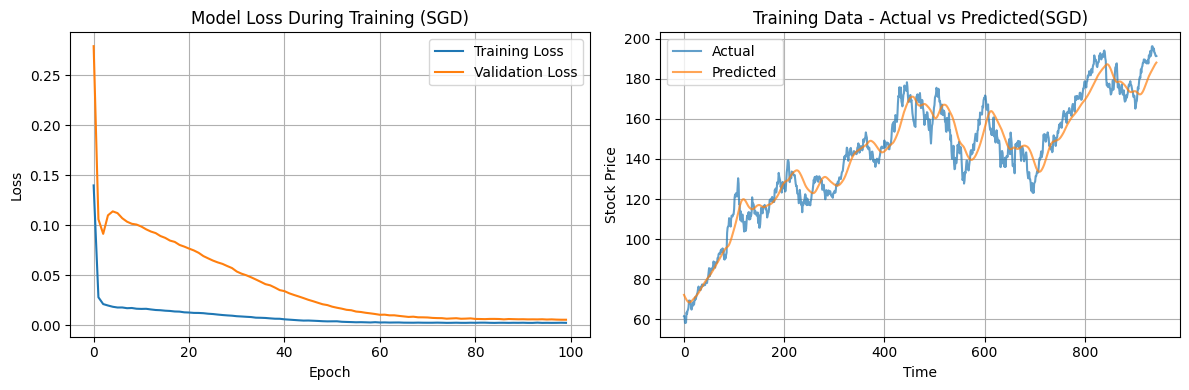

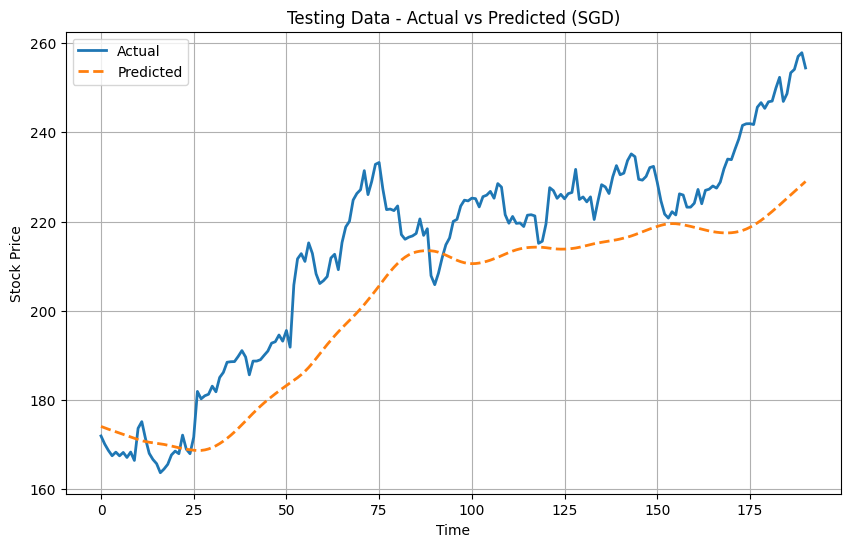

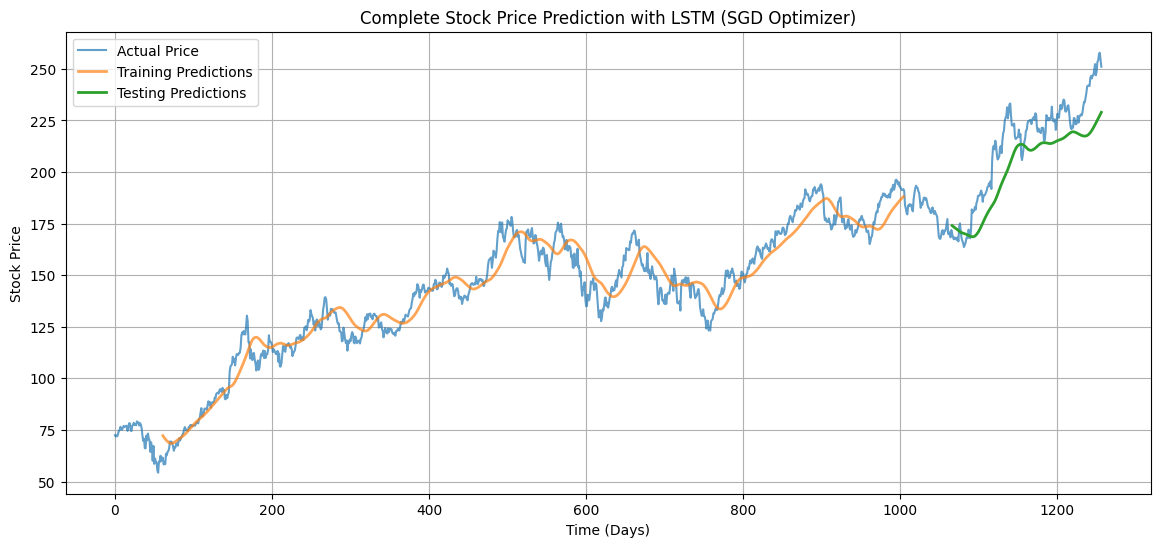

In [ ]:
# -*- coding: utf-8 -*-
"""Stock Predictor with LSTM and SGD Optimizer with Success Rate"""

import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import SGD

# Download historical stock data (e.g., Japanese stock)
data = yf.download("AAPL", start="2020-01-01", end="2024-12-31")
data = data[["Close"]]  # Use only closing price

# Normalize data
scaler = MinMaxScaler()
data["Close"] = scaler.fit_transform(np.array(data["Close"]).reshape(-1, 1))

# Split data into training and testing sets
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]

# Create dataset with lookback period
def create_dataset(dataset, look_back=60):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset['Close'][i:(i + look_back)].values  # Access 'Close' column
        X.append(a)
        Y.append(dataset['Close'].iloc[i + look_back])
    return np.array(X), np.array(Y)

look_back = 60
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create LSTM model
model = Sequential()

# First LSTM layer with return sequences for stacking
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # Dropout for regularization

# Second LSTM layer
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))

# Third LSTM layer
model.add(LSTM(units=100))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(1))

# Compile model with SGD optimizer
model.compile(
    loss='mean_squared_error',
    optimizer=SGD(learning_rate=0.001, momentum=0.9, nesterov=True)  # Using SGD optimizer
)

# Train model
history = model.fit(
    X_train,
    Y_train,
    epochs=100,
    batch_size=64,
    verbose=1,
    validation_data=(X_test, Y_test)  # Added validation for better monitoring
)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
Y_train_original = scaler.inverse_transform(Y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
Y_test_original = scaler.inverse_transform(Y_test.reshape(-1, 1))

# Evaluate the model - Basic metrics
train_rmse = math.sqrt(mean_squared_error(Y_train_original, train_predict))
test_rmse = math.sqrt(mean_squared_error(Y_test_original, test_predict))
print(f'Train RMSE: {train_rmse:.3f}')
print(f'Test RMSE: {test_rmse:.3f}')

train_mae = mean_absolute_error(Y_train_original, train_predict)
test_mae = mean_absolute_error(Y_test_original, test_predict)
print(f'Train MAE: {train_mae:.3f}')
print(f'Test MAE: {test_mae:.3f}')

# ========== CALCULATE SUCCESS RATES ==========
print("\n" + "="*60)
print("SUCCESS RATE CALCULATIONS")
print("="*60)

# 1. Direction Accuracy (Up/Down Prediction)
def calculate_direction_accuracy(actual, predicted):
    """
    Calculate accuracy of predicting price direction (up/down)
    """
    # Calculate actual direction (1 for up, 0 for down, -1 for no change)
    actual_direction = np.sign(np.diff(actual.flatten()))
    predicted_direction = np.sign(np.diff(predicted.flatten()))

    # Align arrays (remove first element since we're comparing directions)
    min_len = min(len(actual_direction), len(predicted_direction))
    actual_direction = actual_direction[:min_len]
    predicted_direction = predicted_direction[:min_len]

    # Calculate accuracy for non-zero directions
    non_zero_mask = (actual_direction != 0) & (predicted_direction != 0)
    if np.sum(non_zero_mask) > 0:
        accuracy = np.mean(actual_direction[non_zero_mask] == predicted_direction[non_zero_mask])
    else:
        accuracy = 0

    return accuracy * 100

# 2. Percentage Error Accuracy (Within X% of actual price)
def calculate_percentage_error_accuracy(actual, predicted, threshold_percent=5):
    """
    Calculate percentage of predictions within threshold_percent of actual price
    """
    percentage_errors = np.abs((actual - predicted) / actual) * 100
    within_threshold = percentage_errors <= threshold_percent
    accuracy = np.mean(within_threshold) * 100
    return accuracy, percentage_errors.mean()

# 3. Trend Following Accuracy (Multiple consecutive correct predictions)
def calculate_trend_following_accuracy(actual, predicted, window=3):
    """
    Calculate accuracy of following trends (multiple consecutive predictions)
    """
    actual_direction = np.sign(np.diff(actual.flatten()))
    predicted_direction = np.sign(np.diff(predicted.flatten()))

    min_len = min(len(actual_direction), len(predicted_direction))
    actual_direction = actual_direction[:min_len]
    predicted_direction = predicted_direction[:min_len]

    correct = (actual_direction == predicted_direction)

    # Calculate rolling accuracy for trend following
    trend_accuracy = []
    for i in range(len(correct) - window + 1):
        if np.sum(correct[i:i+window]) == window:  # All predictions in window are correct
            trend_accuracy.append(1)
        else:
            trend_accuracy.append(0)

    return np.mean(trend_accuracy) * 100 if trend_accuracy else 0

# Calculate success rates for training data
train_direction_acc = calculate_direction_accuracy(Y_train_original, train_predict)
train_percent_acc, train_mean_percent_error = calculate_percentage_error_accuracy(Y_train_original, train_predict, threshold_percent=5)
train_trend_acc = calculate_trend_following_accuracy(Y_train_original, train_predict, window=3)

# Calculate success rates for testing data
test_direction_acc = calculate_direction_accuracy(Y_test_original, test_predict)
test_percent_acc, test_mean_percent_error = calculate_percentage_error_accuracy(Y_test_original, test_predict, threshold_percent=5)
test_trend_acc = calculate_trend_following_accuracy(Y_test_original, test_predict, window=3)

# Print success rate results
print(f"\nTRAINING DATA SUCCESS RATES:")
print(f"1. Direction Prediction Accuracy: {train_direction_acc:.2f}%")
print(f"2. Predictions within 5% of actual price: {train_percent_acc:.2f}%")
print(f"   (Mean Percentage Error: {train_mean_percent_error:.2f}%)")
print(f"3. 3-Day Trend Following Accuracy: {train_trend_acc:.2f}%")

print(f"\nTESTING DATA SUCCESS RATES:")
print(f"1. Direction Prediction Accuracy: {test_direction_acc:.2f}%")
print(f"2. Predictions within 5% of actual price: {test_percent_acc:.2f}%")
print(f"   (Mean Percentage Error: {test_mean_percent_error:.2f}%)")
print(f"3. 3-Day Trend Following Accuracy: {test_trend_acc:.2f}%")

# Calculate overall success score (weighted average)
def calculate_overall_success_score(direction_acc, percent_acc, trend_acc):
    """Calculate weighted overall success score"""
    weights = [0.4, 0.4, 0.2]  # Weights for direction, percentage, and trend accuracy
    return direction_acc * weights[0] + percent_acc * weights[1] + trend_acc * weights[2]

train_overall_score = calculate_overall_success_score(train_direction_acc, train_percent_acc, train_trend_acc)
test_overall_score = calculate_overall_success_score(test_direction_acc, test_percent_acc, test_trend_acc)

print(f"\nOVERALL SUCCESS SCORES (Weighted Average):")
print(f"Training Data Overall Score: {train_overall_score:.2f}%")
print(f"Testing Data Overall Score: {test_overall_score:.2f}%")
print("="*60)

# 4. Trading Simulation Success (If we traded based on predictions)
def simulate_trading(actual, predicted, initial_balance=10000):
    """
    Simulate simple trading based on predictions
    """
    balance = initial_balance
    position = 0  # 0 = no position, 1 = long position
    trades = []

    for i in range(1, len(actual)):
        predicted_change = predicted[i] - predicted[i-1]
        actual_change = actual[i] - actual[i-1]

        # Buy signal: predicted to go up
        if predicted_change > 0 and position == 0:
            position = 1
            trades.append(('buy', actual[i]))

        # Sell signal: predicted to go down and we have position
        elif predicted_change < 0 and position == 1:
            position = 0
            trades.append(('sell', actual[i]))

    # Close any open position at the end
    if position == 1:
        trades.append(('sell', actual[-1]))

    # Calculate profit/loss
    profit_loss = 0
    buy_price = None
    for trade_type, price in trades:
        if trade_type == 'buy':
            buy_price = price
        elif trade_type == 'sell' and buy_price is not None:
            profit_loss += (price - buy_price)
            buy_price = None

    # Calculate return percentage
    return_percentage = (profit_loss / initial_balance) * 100

    # Calculate win rate of trades
    winning_trades = 0
    total_trades = 0
    for i in range(len(trades)-1):
        if trades[i][0] == 'buy' and i+1 < len(trades) and trades[i+1][0] == 'sell':
            total_trades += 1
            if trades[i+1][1] > trades[i][1]:
                winning_trades += 1

    win_rate = (winning_trades / total_trades * 100) if total_trades > 0 else 0

    return return_percentage, win_rate, len(trades)

# Run trading simulation
train_return, train_win_rate, train_num_trades = simulate_trading(Y_train_original.flatten(), train_predict.flatten())
test_return, test_win_rate, test_num_trades = simulate_trading(Y_test_original.flatten(), test_predict.flatten())

print(f"\nTRADING SIMULATION RESULTS:")
print(f"Training Data:")
print(f"  - Return: {train_return:.2f}%")
print(f"  - Win Rate: {train_win_rate:.2f}%")
print(f"  - Number of Trades: {train_num_trades}")
print(f"\nTesting Data:")
print(f"  - Return: {test_return:.2f}%")
print(f"  - Win Rate: {test_win_rate:.2f}%")
print(f"  - Number of Trades: {test_num_trades}")
print("="*60)

# Print additional information
print(f"\nMODEL INFORMATION:")
print(f"Total data points: {len(data)}")
print(f"Training data points: {len(train_data)}")
print(f"Testing data points: {len(test_data)}")
print(f"Look-back period: {look_back} days")
print(f"Training predictions: {len(train_predict)} points")
print(f"Testing predictions: {len(test_predict)} points")
print(f"Optimizer: SGD (learning_rate=0.001, momentum=0.9, nesterov=True)")
print(f"Model Architecture: 3 LSTM layers (100 units each) with Dropout(0.2)")

# Plot training loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training (SGD)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot training data predictions
plt.subplot(1, 2, 2)
plt.plot(Y_train_original, label='Actual', alpha=0.7)
plt.plot(train_predict, label='Predicted', alpha=0.7)
plt.title('Training Data - Actual vs Predicted(SGD)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot testing data predictions
plt.figure(figsize=(10, 6))
plt.plot(Y_test_original, label='Actual', linewidth=2)
plt.plot(test_predict, label='Predicted', linewidth=2, linestyle='--')
plt.title('Testing Data - Actual vs Predicted (SGD)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

# Plot combined view (optional)
plt.figure(figsize=(14, 6))

# Get the original unscaled data
original_prices = scaler.inverse_transform(data['Close'].values.reshape(-1, 1))

# Plot actual prices
plt.plot(original_prices, label='Actual Price', alpha=0.7, linewidth=1.5)

# Plot training predictions - shift to align with original timeline
train_predict_plot = np.empty_like(original_prices)
train_predict_plot[:] = np.nan
train_predict_plot[look_back + 1:look_back + 1 + len(train_predict)] = train_predict

# Plot testing predictions - shift to align with original timeline
test_predict_plot = np.empty_like(original_prices)
test_predict_plot[:] = np.nan
test_start_idx = len(train_data) + look_back + 1
test_end_idx = test_start_idx + len(test_predict)
test_predict_plot[test_start_idx:test_end_idx] = test_predict

plt.plot(train_predict_plot, label='Training Predictions', alpha=0.7, linewidth=2)
plt.plot(test_predict_plot, label='Testing Predictions', linewidth=2)
plt.title('Complete Stock Price Prediction with LSTM (SGD Optimizer)')
plt.xlabel('Time (Days)')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipython-input-1979295507.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("9843.T", start="2020-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


Training model with FTRL optimizer...
Epoch 1/200


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.1422 - val_loss: 0.0633
Epoch 2/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0518 - val_loss: 0.0520
Epoch 3/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0490 - val_loss: 0.0543
Epoch 4/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0483 - val_loss: 0.0513
Epoch 5/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0500 - val_loss: 0.0529
Epoch 6/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0508 - val_loss: 0.0497
Epoch 7/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0493 - val_loss: 0.0506
Epoch 8/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0484 - val_loss: 0.0509
Epoch 9/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0505 - val_loss: 0.0479
Epoch 10/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0498 - val_loss: 0.0459
Epoch 11/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0468 - val_loss: 0.0432
Epoch 12/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0

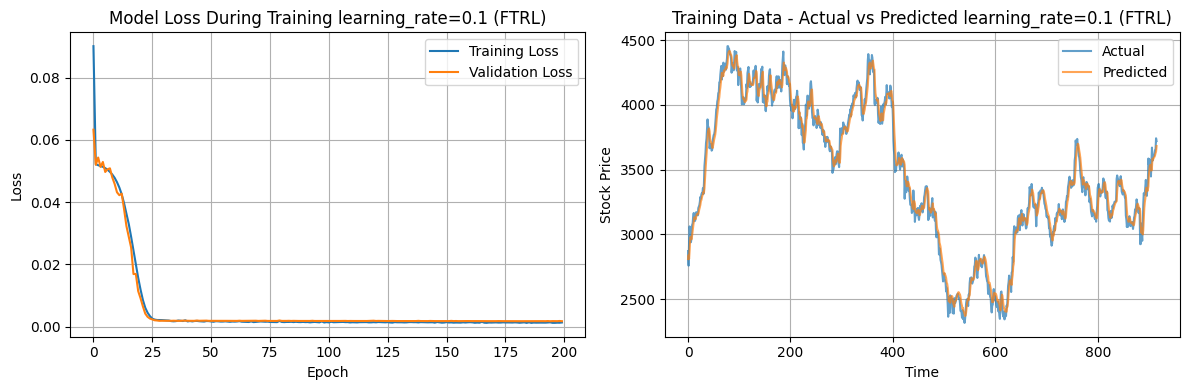

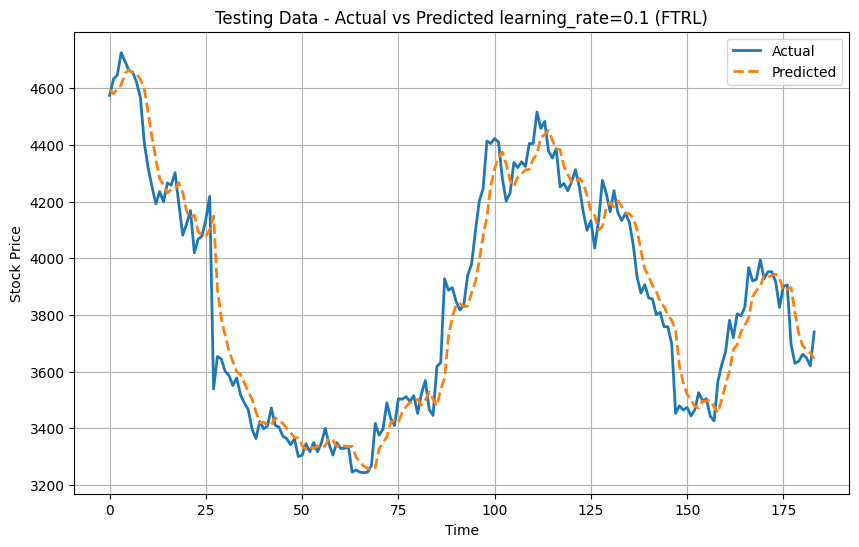

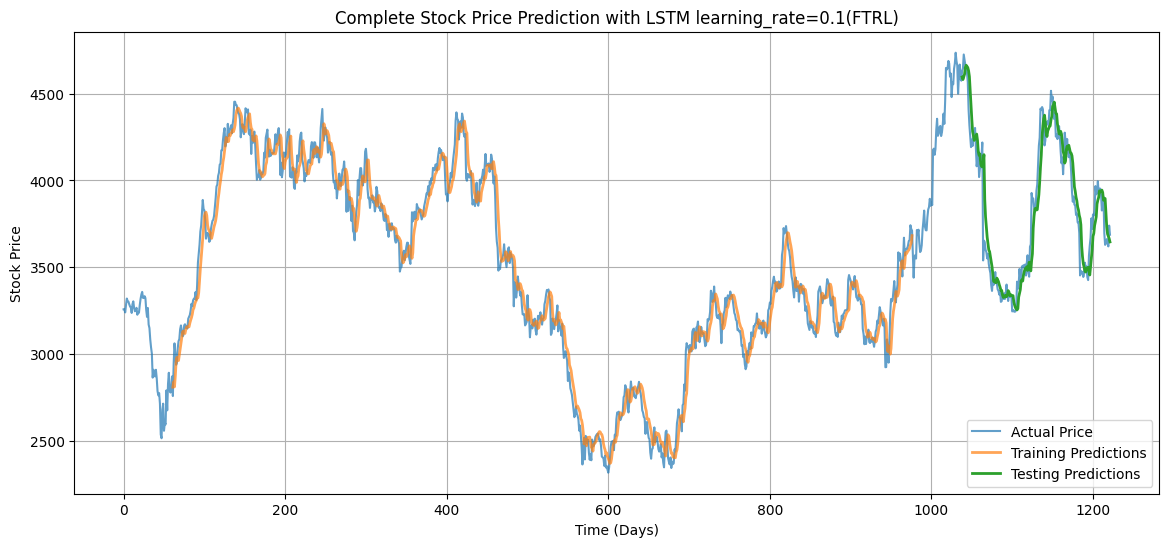

In [ ]:
# -*- coding: utf-8 -*-
"""Stock Predictor with FTRL Optimizer - Working Version"""

import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Ftrl

# Download historical stock data (e.g., Japanese stock)
data = yf.download("9843.T", start="2020-01-01", end="2024-12-31")
data = data[["Close"]]  # Use only closing price

# Normalize data
scaler = MinMaxScaler()
data["Close"] = scaler.fit_transform(np.array(data["Close"]).reshape(-1, 1))

# Split data into training and testing sets
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]

# Create dataset with lookback period
def create_dataset(dataset, look_back=60):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset['Close'][i:(i + look_back)].values  # Access 'Close' column
        X.append(a)
        Y.append(dataset['Close'].iloc[i + look_back])
    return np.array(X), np.array(Y)

look_back = 60
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create LSTM model - SIMPLIFIED for FTRL
model = Sequential()

# Since FTRL works better with simpler architectures, use only 1 LSTM layer
model.add(LSTM(units=50, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # Dropout for regularization

# Output layer
model.add(Dense(1))

# Compile model with FTRL optimizer - ADJUSTED PARAMETERS
model.compile(
    loss='mean_squared_error',
    optimizer=Ftrl(
        learning_rate=0.1,  # Higher learning rate for FTRL
        learning_rate_power=-0.5,
        initial_accumulator_value=1.0,  # Higher initial accumulator
        l1_regularization_strength=0.0,  # No L1 regularization for LSTM
        l2_regularization_strength=0.01,  # Higher L2 for stability
        l2_shrinkage_regularization_strength=0.0
    )
)

# Train model with MORE EPOCHS
print("Training model with FTRL optimizer...")
history = model.fit(
    X_train,
    Y_train,
    epochs=200,  # More epochs for FTRL
    batch_size=32,  # Smaller batch size
    verbose=1,
    validation_data=(X_test, Y_test)
)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
Y_train_original = scaler.inverse_transform(Y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
Y_test_original = scaler.inverse_transform(Y_test.reshape(-1, 1))

# Evaluate the model - Basic metrics
train_rmse = math.sqrt(mean_squared_error(Y_train_original, train_predict))
test_rmse = math.sqrt(mean_squared_error(Y_test_original, test_predict))
print(f'Train RMSE: {train_rmse:.3f}')
print(f'Test RMSE: {test_rmse:.3f}')

train_mae = mean_absolute_error(Y_train_original, train_predict)
test_mae = mean_absolute_error(Y_test_original, test_predict)
print(f'Train MAE: {train_mae:.3f}')
print(f'Test MAE: {test_mae:.3f}')

# ========== CALCULATE SUCCESS RATES ==========
print("\n" + "="*60)
print("SUCCESS RATE CALCULATIONS (FTRL Optimizer)")
print("="*60)

# 1. Direction Accuracy (Up/Down Prediction)
def calculate_direction_accuracy(actual, predicted):
    """
    Calculate accuracy of predicting price direction (up/down)
    """
    # Calculate actual direction (1 for up, 0 for down, -1 for no change)
    actual_direction = np.sign(np.diff(actual.flatten()))
    predicted_direction = np.sign(np.diff(predicted.flatten()))

    # Align arrays (remove first element since we're comparing directions)
    min_len = min(len(actual_direction), len(predicted_direction))
    actual_direction = actual_direction[:min_len]
    predicted_direction = predicted_direction[:min_len]

    # Calculate accuracy for non-zero directions
    non_zero_mask = (actual_direction != 0) & (predicted_direction != 0)
    if np.sum(non_zero_mask) > 0:
        accuracy = np.mean(actual_direction[non_zero_mask] == predicted_direction[non_zero_mask])
    else:
        accuracy = 0

    return accuracy * 100

# 2. Percentage Error Accuracy (Within X% of actual price)
def calculate_percentage_error_accuracy(actual, predicted, threshold_percent=5):
    """
    Calculate percentage of predictions within threshold_percent of actual price
    """
    percentage_errors = np.abs((actual - predicted) / actual) * 100
    within_threshold = percentage_errors <= threshold_percent
    accuracy = np.mean(within_threshold) * 100
    return accuracy, percentage_errors.mean()

# 3. Trend Following Accuracy (Multiple consecutive correct predictions)
def calculate_trend_following_accuracy(actual, predicted, window=3):
    """
    Calculate accuracy of following trends (multiple consecutive predictions)
    """
    actual_direction = np.sign(np.diff(actual.flatten()))
    predicted_direction = np.sign(np.diff(predicted.flatten()))

    min_len = min(len(actual_direction), len(predicted_direction))
    actual_direction = actual_direction[:min_len]
    predicted_direction = predicted_direction[:min_len]

    correct = (actual_direction == predicted_direction)

    # Calculate rolling accuracy for trend following
    trend_accuracy = []
    for i in range(len(correct) - window + 1):
        if np.sum(correct[i:i+window]) == window:  # All predictions in window are correct
            trend_accuracy.append(1)
        else:
            trend_accuracy.append(0)

    return np.mean(trend_accuracy) * 100 if trend_accuracy else 0

# Calculate success rates for training data
train_direction_acc = calculate_direction_accuracy(Y_train_original, train_predict)
train_percent_acc, train_mean_percent_error = calculate_percentage_error_accuracy(Y_train_original, train_predict, threshold_percent=5)
train_trend_acc = calculate_trend_following_accuracy(Y_train_original, train_predict, window=3)

# Calculate success rates for testing data
test_direction_acc = calculate_direction_accuracy(Y_test_original, test_predict)
test_percent_acc, test_mean_percent_error = calculate_percentage_error_accuracy(Y_test_original, test_predict, threshold_percent=5)
test_trend_acc = calculate_trend_following_accuracy(Y_test_original, test_predict, window=3)

# Print success rate results
print(f"\nTRAINING DATA SUCCESS RATES:")
print(f"1. Direction Prediction Accuracy: {train_direction_acc:.2f}%")
print(f"2. Predictions within 5% of actual price: {train_percent_acc:.2f}%")
print(f"   (Mean Percentage Error: {train_mean_percent_error:.2f}%)")
print(f"3. 3-Day Trend Following Accuracy: {train_trend_acc:.2f}%")

print(f"\nTESTING DATA SUCCESS RATES:")
print(f"1. Direction Prediction Accuracy: {test_direction_acc:.2f}%")
print(f"2. Predictions within 5% of actual price: {test_percent_acc:.2f}%")
print(f"   (Mean Percentage Error: {test_mean_percent_error:.2f}%)")
print(f"3. 3-Day Trend Following Accuracy: {test_trend_acc:.2f}%")

# Calculate overall success score (weighted average)
def calculate_overall_success_score(direction_acc, percent_acc, trend_acc):
    """Calculate weighted overall success score"""
    weights = [0.4, 0.4, 0.2]  # Weights for direction, percentage, and trend accuracy
    return direction_acc * weights[0] + percent_acc * weights[1] + trend_acc * weights[2]

train_overall_score = calculate_overall_success_score(train_direction_acc, train_percent_acc, train_trend_acc)
test_overall_score = calculate_overall_success_score(test_direction_acc, test_percent_acc, test_trend_acc)

print(f"\nOVERALL SUCCESS SCORES (Weighted Average):")
print(f"Training Data Overall Score: {train_overall_score:.2f}%")
print(f"Testing Data Overall Score: {test_overall_score:.2f}%")
print("="*60)

# Print additional information
print(f"\nMODEL INFORMATION:")
print(f"Total data points: {len(data)}")
print(f"Training data points: {len(train_data)}")
print(f"Testing data points: {len(test_data)}")
print(f"Look-back period: {look_back} days")
print(f"Training predictions: {len(train_predict)} points")
print(f"Testing predictions: {len(test_predict)} points")
print(f"Optimizer: FTRL")
print(f"Learning rate: 0.1")
print(f"L2 Regularization: 0.01")
print(f"Epochs: 200, Batch size: 32")
print(f"Model Architecture: 1 LSTM layer (50 units) with Dropout(0.2)")
print("\nNote: FTRL is typically used for sparse linear models.")
print("This implementation uses a simplified LSTM architecture for compatibility.")

# Plot training loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training learning_rate=0.1 (FTRL)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot training data predictions
plt.subplot(1, 2, 2)
plt.plot(Y_train_original, label='Actual', alpha=0.7)
plt.plot(train_predict, label='Predicted', alpha=0.7)
plt.title('Training Data - Actual vs Predicted learning_rate=0.1 (FTRL)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot testing data predictions
plt.figure(figsize=(10, 6))
plt.plot(Y_test_original, label='Actual', linewidth=2)
plt.plot(test_predict, label='Predicted', linewidth=2, linestyle='--')
plt.title('Testing Data - Actual vs Predicted learning_rate=0.1 (FTRL)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

# Plot combined view (optional)
plt.figure(figsize=(14, 6))

# Get the original unscaled data
original_prices = scaler.inverse_transform(data['Close'].values.reshape(-1, 1))

# Plot actual prices
plt.plot(original_prices, label='Actual Price', alpha=0.7, linewidth=1.5)

# Plot training predictions - shift to align with original timeline
train_predict_plot = np.empty_like(original_prices)
train_predict_plot[:] = np.nan
train_predict_plot[look_back + 1:look_back + 1 + len(train_predict)] = train_predict

# Plot testing predictions - shift to align with original timeline
test_predict_plot = np.empty_like(original_prices)
test_predict_plot[:] = np.nan
test_start_idx = len(train_data) + look_back + 1
test_end_idx = test_start_idx + len(test_predict)
test_predict_plot[test_start_idx:test_end_idx] = test_predict

plt.plot(train_predict_plot, label='Training Predictions', alpha=0.7, linewidth=2)
plt.plot(test_predict_plot, label='Testing Predictions', linewidth=2)
plt.title('Complete Stock Price Prediction with LSTM learning_rate=0.1(FTRL)')
plt.xlabel('Time (Days)')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()